# Qn1a)

In [ ]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
no_labels = 1
no_features = 2
no_exps = 10

lr = 0.05
no_epochs = 5000
patience = 10

hidden_units = [2,4,6,8,10]

In [ ]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
class MLP(nn.Module):
  def __init__(self, no_features, no_hidden, no_labels):
    super().__init__()
    self.mlp_stack = nn.Sequential(
        nn.Linear(no_features, no_hidden),
        nn.Sigmoid(),
        nn.Linear(no_hidden, no_labels),
    )

  def forward(self, x):
    logits = self.mlp_stack(x)
    return logits

In [ ]:
class EarlyStopper:
  def __init__(self, patience=10, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_validation_loss = np.inf

  def early_stop(self, validation_loss):
    if validation_loss < self.min_validation_loss:
      self.min_validation_loss = validation_loss
      self.counter = 0
    elif validation_loss > (self.min_validation_loss + self.min_delta):
      self.counter += 1
      if self.counter >= self.patience:
        return True
    return False

In [ ]:
def train_exp(X,Y):
  x_train, y_train, x_test, y_test = X[:70], Y[:70], X[70:], Y[70:]

  loss_ = []
  for no_hidden in hidden_units:
      model = MLP(no_features, no_hidden, no_labels)

      loss_fn = torch.nn.MSELoss()
      optimizer = torch.optim.SGD(model.parameters(),lr=lr)
      early_stopper = EarlyStopper(patience=patience, min_delta=0)

      for epoch in range(no_epochs):
        pred = model(torch.tensor(x_train, dtype=torch.float))
        train_loss = loss_fn(pred, torch.tensor(y_train, dtype=torch.float))

        # Backpropagation
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        pred = model(torch.tensor(x_test, dtype=torch.float))
        test_loss = loss_fn(pred, torch.tensor(y_test, dtype=torch.float))

        if early_stopper.early_stop(test_loss):
          break

      loss_.append(test_loss.item())

  return loss_

In [ ]:
# generate training data
X = np.zeros((10*10, 2))
no_data = 0
for i in np.arange(-1.0,1.001,2.0/9.0):
  for j in np.arange(-1.0,1.001,2.0/9.0):
    X[no_data] = [i, j]
    no_data += 1

Y = np.zeros((no_data,1))
Y[:,0] = np.sin(np.pi*X[:,0])*np.cos(2*np.pi*X[:,1])

In [ ]:
idx = np.arange(no_data)

# perform experiments
err = []
print('hidden units: {}'.format(hidden_units))
for exp in range(no_exps):
  np.random.shuffle(idx)
  err.append(train_exp(X[idx],Y[idx]))
  print('exp: {}, errors: {}'.format(exp, np.array(err[exp])))

hidden units: [2, 4, 6, 8, 10]
exp: 0, errors: [0.31180772 0.31221333 0.30825767 0.30583131 0.32371911]
exp: 1, errors: [0.18281141 0.18256514 0.18550874 0.18528558 0.17370273]
exp: 2, errors: [0.24535613 0.23845761 0.2406922  0.2469285  0.24165829]
exp: 3, errors: [0.22513752 0.21813853 0.22147274 0.21525638 0.21561465]
exp: 4, errors: [0.24940346 0.24727154 0.24623972 0.25435033 0.25516379]
exp: 5, errors: [0.25583172 0.25079072 0.24044172 0.249007   0.2754139 ]
exp: 6, errors: [0.22024322 0.22234029 0.22123598 0.22461762 0.23194942]
exp: 7, errors: [0.21609326 0.2305754  0.23943795 0.24411394 0.23677669]
exp: 8, errors: [0.23604523 0.23236625 0.23800306 0.2530888  0.24641295]
exp: 9, errors: [0.24079554 0.24114351 0.25327283 0.23831905 0.25188625]


In [ ]:
mean_err = np.mean(np.array(err),axis=0)
print('mean errors: {}'.format(mean_err))
print(' *hidden units* %d '%hidden_units[np.argmin(mean_err)])

mean errors: [0.23835252 0.23758623 0.23945626 0.24167985 0.24522978]
 *hidden units* 4 


Text(0, 0.5, 'mean error')

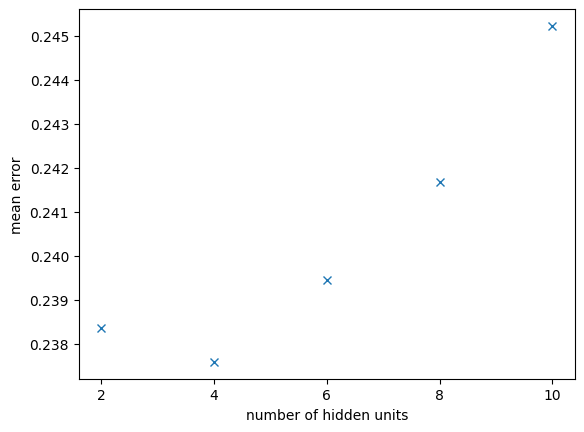

In [ ]:
plt.figure(1)
plt.plot(hidden_units, mean_err, marker = 'x', linestyle = 'None')
plt.xticks(hidden_units)
plt.xlabel('number of hidden units')
plt.ylabel('mean error')

# Qn1b)

In [ ]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
no_labels = 1
no_features = 2
no_exps = 10

lr = 0.05
no_epochs = 5000
patience = 10
no_folds = 5

hidden_units = [2,4,6,8,10]

In [ ]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
class MLP(nn.Module):
  def __init__(self, no_features, no_hidden, no_labels):
    super().__init__()
    self.mlp_stack = nn.Sequential(
        nn.Linear(no_features, no_hidden),
        nn.Sigmoid(),
        nn.Linear(no_hidden, no_labels),
    )

  def forward(self,x):
    logits = self.mlp_stack(x)
    return logits

In [ ]:
class EarlyStopper:
  def __init__(self,patience = 10, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_validation_loss = np.inf

  def early_stop(self, validation_loss):
    if validation_loss < self.min_validation_loss:
      self.min_validation_loss = validation_loss
      self.counter = 0
    elif validation_loss > (self.min_validation_loss + self.min_delta):
      self.counter += 1
      if self.counter >= self.patience:
        return True
    return False

In [ ]:
# perform experiments
def train_exp(X,Y):
  err = []
  for fold in range(no_folds):
    start, end = fold*20, (fold+1)*20
    x_test, y_test = X[start:end], Y[start:end]
    x_train = np.append(X[:start], X[end:], axis=0)
    y_train = np.append(Y[:start], Y[end:], axis=0)

    err_ = []
    for no_hidden in hidden_units:
      model = MLP(no_features, no_hidden, no_labels)

      loss_fn = torch.nn.MSELoss()
      optimizer = torch.optim.SGD(model.parameters(), lr=lr)
      early_stopper = EarlyStopper(patience=patience, min_delta=0)

      for epoch in range(no_epochs):
        pred = model(torch.tensor(x_train, dtype=torch.float))
        train_loss = loss_fn(pred, torch.tensor(y_train, dtype=torch.float))

        # Backpropagation
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        pred = model(torch.tensor(x_test, dtype=torch.float))
        test_loss = loss_fn(pred, torch.tensor(y_test, dtype=torch.float))

        if early_stopper.early_stop(test_loss):
          break

      err_.append(test_loss.item())

    err.append(err_)

  cv_err = np.mean(np.array(err),axis=0)

  return cv_err

In [ ]:
# generate training data
X = np.zeros((10*10, 2))
no_data = 0
for i in np.arange(-1.0,1.001,2.0/9.0):
  for j in np.arange(-1.0,1.001,2.0/9.0):
    X[no_data] = [i,j]
    no_data += 1

Y = np.zeros((no_data, 1))
Y[:,0] = np.sin(np.pi*X[:,0])*np.cos(2*np.pi*X[:,1])

In [ ]:
idx = np.arange(no_data)

# perform experiments
err = []
print('hidden units: {}'.format(hidden_units))
for exp in range(no_exps):
  np.random.shuffle(idx)
  err.append(train_exp(X[idx], Y[idx]))
  print('exp: {}, errors: {}'.format(exp, np.array(err[exp])))

hidden units: [2, 4, 6, 8, 10]
exp: 0, errors: [0.25577456 0.25821493 0.25848609 0.25826615 0.25879999]
exp: 1, errors: [0.24941771 0.25332876 0.25411883 0.25724181 0.25325494]
exp: 2, errors: [0.24673392 0.24635754 0.24887361 0.2462817  0.24619483]
exp: 3, errors: [0.25346066 0.25304357 0.2525975  0.26532594 0.26135474]
exp: 4, errors: [0.2472303  0.24875606 0.24613964 0.24990766 0.24625027]
exp: 5, errors: [0.244274   0.2547805  0.25356148 0.25389109 0.25984086]
exp: 6, errors: [0.24916766 0.25874799 0.25113446 0.24520364 0.24098558]
exp: 7, errors: [0.24976752 0.25541819 0.25289933 0.24666853 0.25296013]
exp: 8, errors: [0.25283271 0.2520413  0.24888387 0.24878774 0.24916868]
exp: 9, errors: [0.25099337 0.24930138 0.25368094 0.25067525 0.24675872]


In [ ]:
# print thhe mean errors of different models
mean_err = np.mean(np.array(err),axis = 0)
print('mean errors: {}'.format(mean_err))
print(' *hidden_units* %d '%hidden_units[np.argmin(mean_err)])

mean errors: [0.24996524 0.25299902 0.25203757 0.25222495 0.25155687]
 *hidden_units* 2 


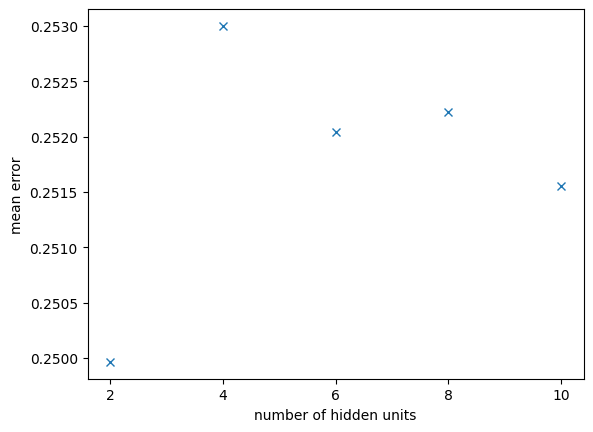

In [ ]:
plt.figure(1)
plt.plot(hidden_units, mean_err, marker = 'x', linestyle = 'None')
plt.xticks(hidden_units)
plt.xlabel('number of hidden units')
plt.ylabel('mean error')
plt.show()

# Qn1c)

In [ ]:
import torch
from torch import nn

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
no_labels = 1
no_features = 2
no_exps = 10

lr = 0.05
no_epochs = 5000
patience = 10

hidden_units = [2,4,6,8,10]

In [ ]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
class MLP(nn.Module):
  def __init__(self, no_features, no_hidden, no_labels):
    super().__init__()
    self.mlp_stack = nn.Sequential(
        nn.Linear(no_features, no_hidden),
        nn.Sigmoid(),
        nn.Linear(no_hidden, no_labels),
    )

  def forward(self, x):
    logits = self.mlp_stack(x)
    return logits

In [ ]:
class EarlyStopper:
  def __init__(self, patience=10, min_delta = 0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_validation_loss = np.inf

  def early_stop(self, validation_loss):
    if validation_loss < self.min_validation_loss:
      self.min_validation_loss = validation_loss
      self.counter = 0
    elif validation_loss > (self.min_validation_loss + self.min_delta):
      self.counter += 1
      if self.counter >= self.patience:
        return True
    return False

In [ ]:
# perform experiments
def train_exp(X, Y):
  x_test, y_test = X[:34], Y[:34]
  x_train, y_train = X[34:77], Y[34:77]
  x_valid, y_valid = X[77:], Y[77:]

  err = []
  for no_hidden in hidden_units:

    model = MLP(no_features, no_hidden, no_labels)

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=lr)
    early_stopper = EarlyStopper(patience=patience, min_delta=0)

    for epoch in range(no_epochs):
      pred = model(torch.tensor(x_train, dtype=torch.float))
      train_loss = loss_fn(pred, torch.tensor(y_train, dtype=torch.float))

      # Backpropagation
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()

      pred = model(torch.tensor(x_valid, dtype=torch.float))
      valid_loss = loss_fn(pred, torch.tensor(y_valid, dtype=torch.float))

      if early_stopper.early_stop(valid_loss):
        break

    err.append(valid_loss.item())

  no_hidden = hidden_units[np.argmin(err)]
  x_train, y_train = X[34:], Y[34:]

  model = MLP(no_features, no_hidden, no_labels)

  loss_fn = torch.nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(),lr=lr)
  early_stopper = EarlyStopper(patience=patience, min_delta=0)

  for epoch in range(no_epochs):
    pred = model(torch.tensor(x_train, dtype=torch.float))
    train_loss = loss_fn(pred, torch.tensor(y_train, dtype=torch.float))

    # Backpropagation
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    pred = model(torch.tensor(x_test, dtype=torch.float))
    test_loss = loss_fn(pred, torch.tensor(y_test, dtype=torch.float))

    if early_stopper.early_stop(train_loss):
      break

  return no_hidden, test_loss.item()

In [ ]:
# generate training data
X = np.zeros((10*10,2))
no_data = 0
for i in np.arange(-1.0,1.001,2.0/9.0):
  for j in np.arange(-1.0,1.001,2.0/9.0):
    X[no_data] = [i,j]
    no_data += 1
Y = np.zeros((no_data,1))
Y[:,0] = np.sin(np.pi*X[:,0])*np.cos(2*np.pi*X[:,1])

In [ ]:
idx = np.arange(no_data)

# perform experiments
no_hidden, err = [], []
print('hidden units: {}'.format(hidden_units))
for exp in range(no_exps):
  np.random.shuffle(idx)
  no_hidden_, err_ = train_exp(X[idx], Y[idx])

  no_hidden.append(no_hidden_)
  err.append(err_)

  print('exp %d, hidden units %d, error %g'%(exp, no_hidden[exp], err[exp]))

hidden units: [2, 4, 6, 8, 10]
exp 0, hidden units 8, error 0.2155
exp 1, hidden units 8, error 0.319126
exp 2, hidden units 2, error 0.291044
exp 3, hidden units 6, error 0.269409
exp 4, hidden units 2, error 0.240611
exp 5, hidden units 2, error 0.285371
exp 6, hidden units 4, error 0.341918
exp 7, hidden units 2, error 0.22846
exp 8, hidden units 4, error 0.339149
exp 9, hidden units 4, error 0.235382


In [ ]:
# Find the consensus of experiments
hidden_counts = np.zeros(len(hidden_units)).astype(int)
for exp in range(no_exps):
  hidden_counts[no_hidden[exp]//2-1] += 1

print(hidden_counts)
opt_hidden = hidden_units[np.argmax(hidden_counts)]
print('* %d *'%opt_hidden)

print('error = %g'%np.mean(err[no_hidden == opt_hidden]))

[4 3 1 2 0]
* 2 *
error = 0.2155


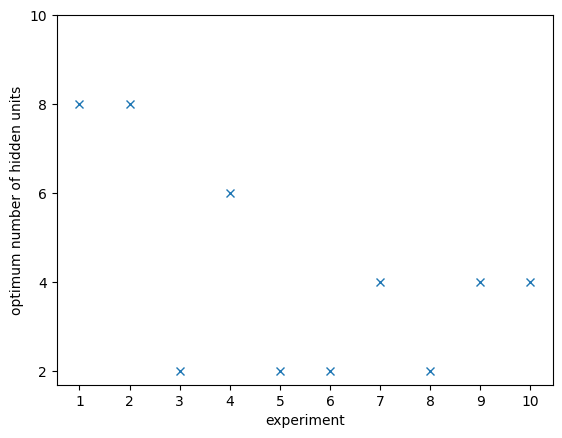

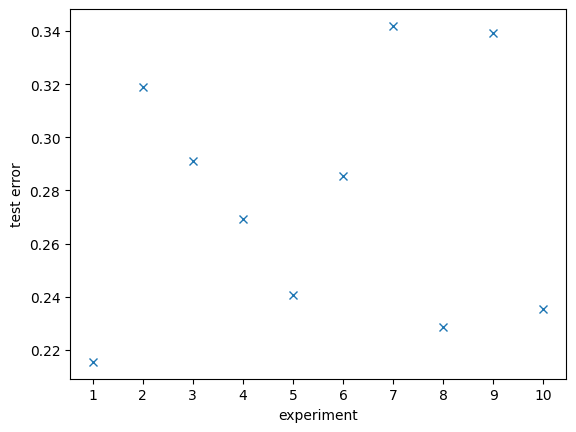

In [ ]:
# plot the results
plt.figure(1)
plt.plot(range(no_exps), no_hidden, marker = 'x', linestyle = 'None')
plt.yticks(hidden_units)
plt.xticks(range(no_exps), np.arange(no_exps)+1)
plt.xlabel('experiment')
plt.ylabel('optimum number of hidden units')
plt.show()

plt.figure(2)
plt.plot(range(no_exps), err, marker = 'x', linestyle = 'None')
plt.xticks(range(no_exps), np.arange(no_exps)+1)
plt.xlabel('experiment')
plt.ylabel('test error')
plt.show()

# Qn2a)

In [ ]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms

import numpy as np

In [ ]:
batch_size = 256
max_epochs = 100
patience = 10

device = "mps"

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train = True, download = True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_dataloader= torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:01<00:00, 102MB/s]


In [ ]:
class NeuralNetwork(nn.Module):
  def __init__(self, hidden_size=100):
    super(NeuralNetwork, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(32*32*3, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, 10),
        nn.Softmax(dim=1)
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  train_loss, train_correct = 0,0
  for batch, (X,y) in enumerate(dataloader):
    # Compute prediction and loss
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  train_loss /= size
  train_correct /= size

  return train_loss, train_correct


def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, test_correct = 0,0

  with torch.no_grad():
    for X, y in dataloader:
      pred = model(X)
      test_loss += loss_fn(pred,y).item()
      test_correct += (pred.argmax(1)==y).type(torch.float).sum().item()

  test_loss /= size
  test_correct /= size

  return test_loss, test_correct

In [ ]:
class EarlyStopper:
  def __init__(self, patience=10, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_validation_loss = np.inf

  def early_stop(self, validation_loss):
    if validation_loss < self.min_validation_loss:
      self.min_validation_loss = validation_loss
      self.counter=0
    elif validation_loss > (self.min_validation_loss + self.min_delta):
      self.counter += 1
      if self.counter >= self.patience:
        return True
    return False

In [ ]:
model = NeuralNetwork(hidden_size=50)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
early_stopper = EarlyStopper(patience=patience, min_delta=0)

tr1_loss, tr1_correct = [], []
te1_loss, te1_correct = [], []
for t in range(max_epochs):
  train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
  test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)

  tr1_loss.append(train_loss), tr1_correct.append(train_correct)
  te1_loss.append(test_loss), te1_correct.append(test_correct)

  print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy:{(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

  if early_stopper.early_stop(test_loss):
    print("Done")
    break

Epoch 1: Train_accuracy: 31.56%, Train_loss: 0.008389, Test_accuracy:38.67%, Test_loss: 0.008288
Epoch 2: Train_accuracy: 40.64%, Train_loss: 0.008034, Test_accuracy:41.82%, Test_loss: 0.008162
Epoch 3: Train_accuracy: 43.83%, Train_loss: 0.007918, Test_accuracy:43.84%, Test_loss: 0.008083
Epoch 4: Train_accuracy: 45.69%, Train_loss: 0.007846, Test_accuracy:45.11%, Test_loss: 0.008026
Epoch 5: Train_accuracy: 47.29%, Train_loss: 0.007787, Test_accuracy:44.73%, Test_loss: 0.008044
Epoch 6: Train_accuracy: 48.53%, Train_loss: 0.007735, Test_accuracy:45.21%, Test_loss: 0.008034
Epoch 7: Train_accuracy: 49.33%, Train_loss: 0.007709, Test_accuracy:45.52%, Test_loss: 0.008003
Epoch 8: Train_accuracy: 50.09%, Train_loss: 0.007680, Test_accuracy:45.46%, Test_loss: 0.008008
Epoch 9: Train_accuracy: 50.99%, Train_loss: 0.007645, Test_accuracy:47.34%, Test_loss: 0.007945
Epoch 10: Train_accuracy: 51.79%, Train_loss: 0.007612, Test_accuracy:47.13%, Test_loss: 0.007941
Epoch 11: Train_accuracy: 52.

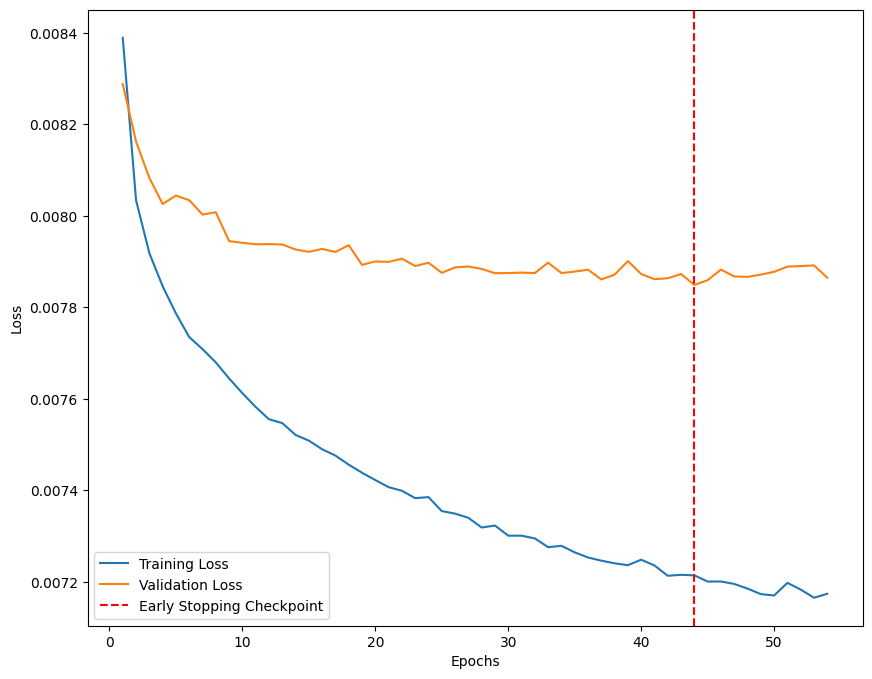

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr1_loss)+1), tr1_loss, label='Training Loss')
plt.plot(range(1,len(te1_loss)+1), te1_loss, label='Validation Loss')

# find position of lowest validation loss
minposs = te1_loss.index(min(te1_loss))+1
plt.axvline(minposs, linestyle='--',color='r', label='Early Stopping Checkpoint')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model = NeuralNetwork(hidden_size=100)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
early_stopper = EarlyStopper(patience=patience, min_delta=0)

tr2_loss, tr2_correct = [], []
te2_loss, te2_correct = [], []
for t in range(max_epochs):
  train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
  test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)

  tr2_loss.append(train_loss), tr2_correct.append(train_correct)
  te2_loss.append(test_loss), te2_correct.append(test_correct)

  print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy:{(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

  if early_stopper.early_stop(test_loss):
    print("Done")
    break

Epoch 1: Train_accuracy: 34.04%, Train_loss: 0.008287, Test_accuracy:39.81%, Test_loss: 0.008226
Epoch 2: Train_accuracy: 41.22%, Train_loss: 0.008013, Test_accuracy:42.62%, Test_loss: 0.008122
Epoch 3: Train_accuracy: 44.21%, Train_loss: 0.007898, Test_accuracy:44.29%, Test_loss: 0.008066
Epoch 4: Train_accuracy: 46.02%, Train_loss: 0.007826, Test_accuracy:44.84%, Test_loss: 0.008034
Epoch 5: Train_accuracy: 47.97%, Train_loss: 0.007752, Test_accuracy:45.88%, Test_loss: 0.007978
Epoch 6: Train_accuracy: 49.55%, Train_loss: 0.007692, Test_accuracy:47.91%, Test_loss: 0.007906
Epoch 7: Train_accuracy: 51.04%, Train_loss: 0.007640, Test_accuracy:48.16%, Test_loss: 0.007909
Epoch 8: Train_accuracy: 51.91%, Train_loss: 0.007601, Test_accuracy:47.41%, Test_loss: 0.007935
Epoch 9: Train_accuracy: 52.75%, Train_loss: 0.007572, Test_accuracy:48.25%, Test_loss: 0.007920
Epoch 10: Train_accuracy: 53.70%, Train_loss: 0.007536, Test_accuracy:48.80%, Test_loss: 0.007881
Epoch 11: Train_accuracy: 54.

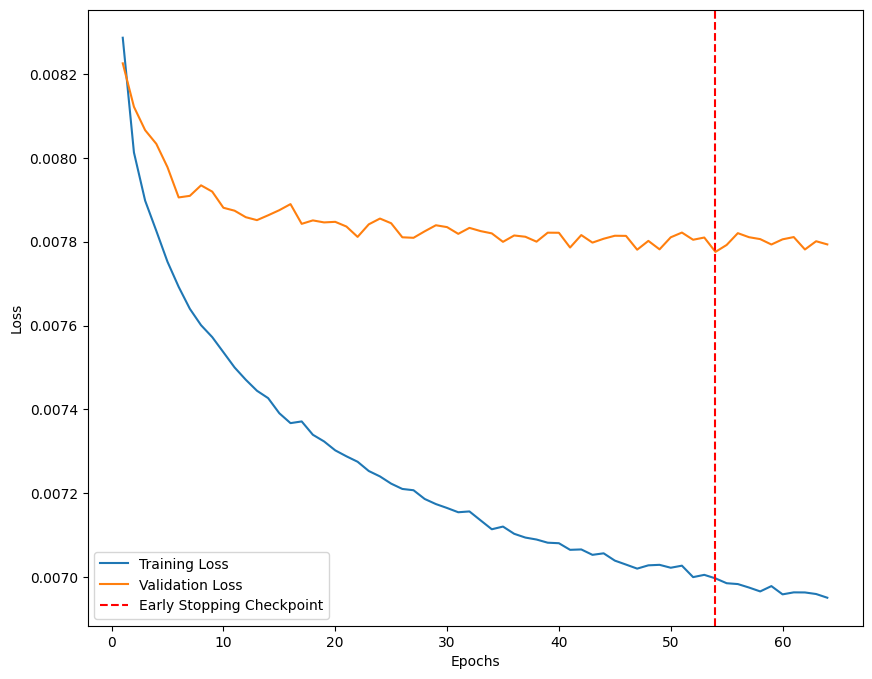

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr2_loss)+1), tr2_loss, label='Training Loss')
plt.plot(range(1,len(te2_loss)+1), te2_loss, label='Validation Loss')

# find position of lowest validation loss
minposs = te2_loss.index(min(te2_loss))+1
plt.axvline(minposs, linestyle='--',color='r', label='Early Stopping Checkpoint')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model = NeuralNetwork(hidden_size=500)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
early_stopper = EarlyStopper(patience=patience, min_delta=0)

tr3_loss, tr3_correct = [], []
te3_loss, te3_correct = [], []
for t in range(max_epochs):
  train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
  test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)

  tr3_loss.append(train_loss), tr3_correct.append(train_correct)
  te3_loss.append(test_loss), te3_correct.append(test_correct)

  print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy:{(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

  if early_stopper.early_stop(test_loss):
    print("Done")
    break

Epoch 1: Train_accuracy: 32.06%, Train_loss: 0.008357, Test_accuracy:37.24%, Test_loss: 0.008344
Epoch 2: Train_accuracy: 38.58%, Train_loss: 0.008116, Test_accuracy:36.87%, Test_loss: 0.008351
Epoch 3: Train_accuracy: 39.21%, Train_loss: 0.008093, Test_accuracy:39.38%, Test_loss: 0.008280
Epoch 4: Train_accuracy: 40.74%, Train_loss: 0.008036, Test_accuracy:37.79%, Test_loss: 0.008325
Epoch 5: Train_accuracy: 40.07%, Train_loss: 0.008067, Test_accuracy:38.95%, Test_loss: 0.008290
Epoch 6: Train_accuracy: 40.92%, Train_loss: 0.008038, Test_accuracy:37.30%, Test_loss: 0.008350
Epoch 7: Train_accuracy: 39.03%, Train_loss: 0.008110, Test_accuracy:40.80%, Test_loss: 0.008230
Epoch 8: Train_accuracy: 39.04%, Train_loss: 0.008111, Test_accuracy:37.28%, Test_loss: 0.008360
Epoch 9: Train_accuracy: 39.94%, Train_loss: 0.008077, Test_accuracy:39.58%, Test_loss: 0.008269
Epoch 10: Train_accuracy: 40.07%, Train_loss: 0.008072, Test_accuracy:39.78%, Test_loss: 0.008264
Epoch 11: Train_accuracy: 39.

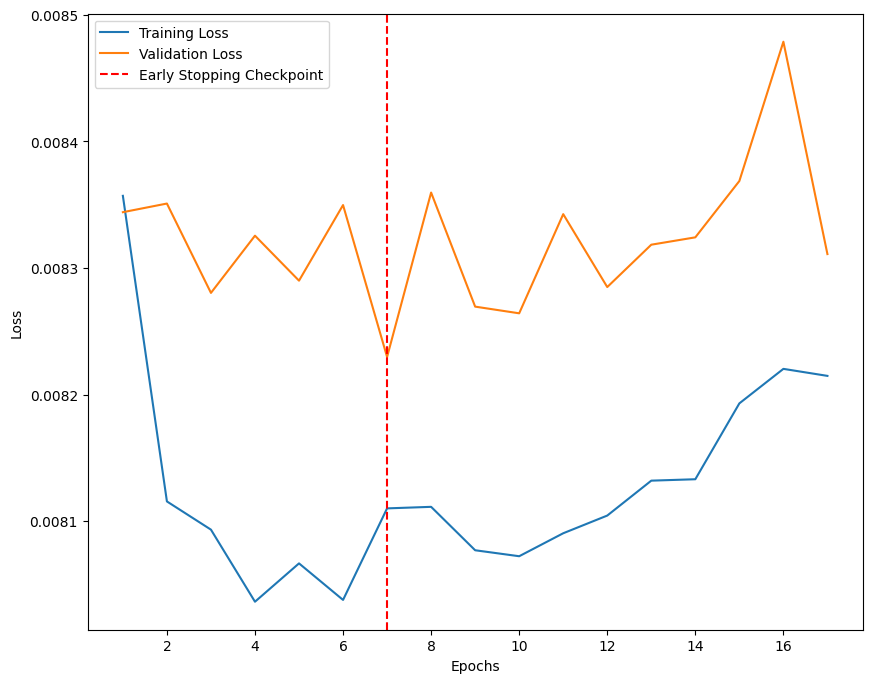

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr3_loss)+1), tr3_loss, label='Training Loss')
plt.plot(range(1,len(te3_loss)+1), te3_loss, label='Validation Loss')

# find position of lowest validation loss
minposs = te3_loss.index(min(te3_loss))+1
plt.axvline(minposs, linestyle='--',color='r', label='Early Stopping Checkpoint')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

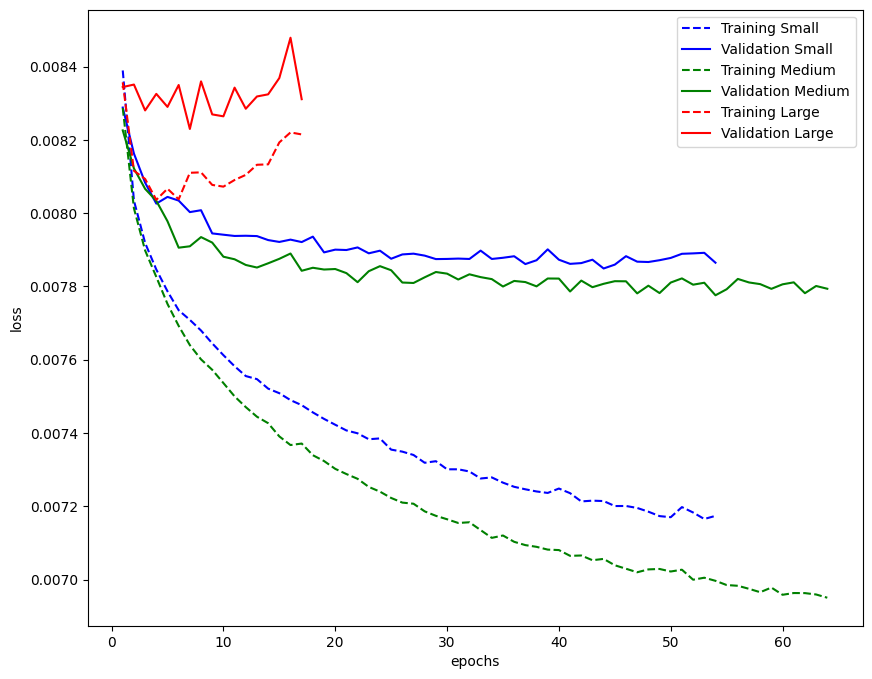

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr1_loss)+1), tr1_loss, linestyle='--', color='b', label='Training Small')
plt.plot(range(1,len(te1_loss)+1), te1_loss, color = 'b', label='Validation Small')
plt.plot(range(1,len(tr2_loss)+1), tr2_loss, linestyle='--', color='g', label='Training Medium')
plt.plot(range(1,len(te2_loss)+1), te2_loss, color = 'g', label='Validation Medium')
plt.plot(range(1,len(tr3_loss)+1), tr3_loss, linestyle='--', color='r', label='Training Large')
plt.plot(range(1,len(te3_loss)+1), te3_loss, color = 'r', label='Validation Large')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# Qn2b)

In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms

import numpy as np

In [2]:
batch_size = 256
max_epochs = 100
patience = 10
dropouts = 0.2
weight_decay = 0.001

seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Choose 12000 images for training, 2000 images for testing
train_data_subset = torch.utils.data.Subset(trainset, range(25000))
test_data_subset = torch.utils.data.Subset(testset, range(4000))

train_dataloader = torch.utils.data.DataLoader(train_data_subset, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_data_subset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:02<00:00, 74.5MB/s]


In [11]:
class NeuralNetwork(nn.Module):
  def __init__(self,hidden_size=500):
    super(NeuralNetwork, self).__init__()
    self.flatten=nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(32*32*3, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size,10),
        nn.Softmax(dim=1)
    )

  def forward(self,x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

In [12]:
class NeuralNetwork_dropout(nn.Module):
  def __init__(self, hidden_size=100, drop_out=0.5):
    super(NeuralNetwork_dropout, self).__init__()
    self.flatten=nn.Flatten()
    self.linear_relu_stack=nn.Sequential(
        nn.Linear(32*32*3, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Dropout(p=drop_out),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Dropout(p=drop_out),
        nn.Linear(hidden_size, 10),
        nn.Softmax(dim=1)
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  train_loss, train_correct = 0,0
  for batch, (X,y) in enumerate(dataloader):
    # Compute prediction and loss
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    train_correct += (pred.argmax(1)==y).type(torch.float).sum().item()

  train_loss /= size
  train_correct /= size

  return train_loss, train_correct

def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, test_correct = 0,0

  with torch.no_grad():
    for X,y in dataloader:
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      test_correct += (pred.argmax(1)==y).type(torch.float).sum().item()

  test_loss /= size
  test_correct /= size

  return test_loss, test_correct

In [14]:
class EarlyStopper:
  def __init__(self, patience=10, min_delta=0):
    self.patience=patience
    self.min_delta=min_delta
    self.counter=0
    self.min_validation_loss = np.inf

  def early_stop(self, validation_loss):
    if validation_loss < self.min_validation_loss:
      self.min_validation_loss = validation_loss
      self.counter = 0
    elif validation_loss > (self.min_validation_loss + self.min_delta):
      self.counter+=1
      if self.counter >= self.patience:
        return True
    return False

In [16]:
model = NeuralNetwork(hidden_size=500)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
early_stopper = EarlyStopper(patience=patience, min_delta=0)

tr_loss, tr_correct = [],[]
te_loss, te_correct = [],[]
for t in range(max_epochs):
  train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
  test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)

  tr_loss.append(train_loss), tr_correct.append(train_correct)
  te_loss.append(test_loss), te_correct.append(test_correct)

  print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

  if early_stopper.early_stop(test_loss):
    print("Done")
    break

Epoch 1: Train_accuracy: 30.94%, Train_loss: 0.008402, Test_accuracy: 34.77%, Test_loss: 0.008438
Epoch 2: Train_accuracy: 35.76%, Train_loss: 0.008222, Test_accuracy: 37.30%, Test_loss: 0.008321
Epoch 3: Train_accuracy: 38.60%, Train_loss: 0.008117, Test_accuracy: 36.68%, Test_loss: 0.008353
Epoch 4: Train_accuracy: 39.16%, Train_loss: 0.008099, Test_accuracy: 38.80%, Test_loss: 0.008278
Epoch 5: Train_accuracy: 41.59%, Train_loss: 0.008006, Test_accuracy: 40.25%, Test_loss: 0.008227
Epoch 6: Train_accuracy: 42.28%, Train_loss: 0.007974, Test_accuracy: 38.90%, Test_loss: 0.008269
Epoch 7: Train_accuracy: 42.53%, Train_loss: 0.007966, Test_accuracy: 40.27%, Test_loss: 0.008219
Epoch 8: Train_accuracy: 43.38%, Train_loss: 0.007932, Test_accuracy: 41.12%, Test_loss: 0.008186
Epoch 9: Train_accuracy: 44.00%, Train_loss: 0.007911, Test_accuracy: 42.48%, Test_loss: 0.008137
Epoch 10: Train_accuracy: 44.92%, Train_loss: 0.007876, Test_accuracy: 42.10%, Test_loss: 0.008153
Epoch 11: Train_acc

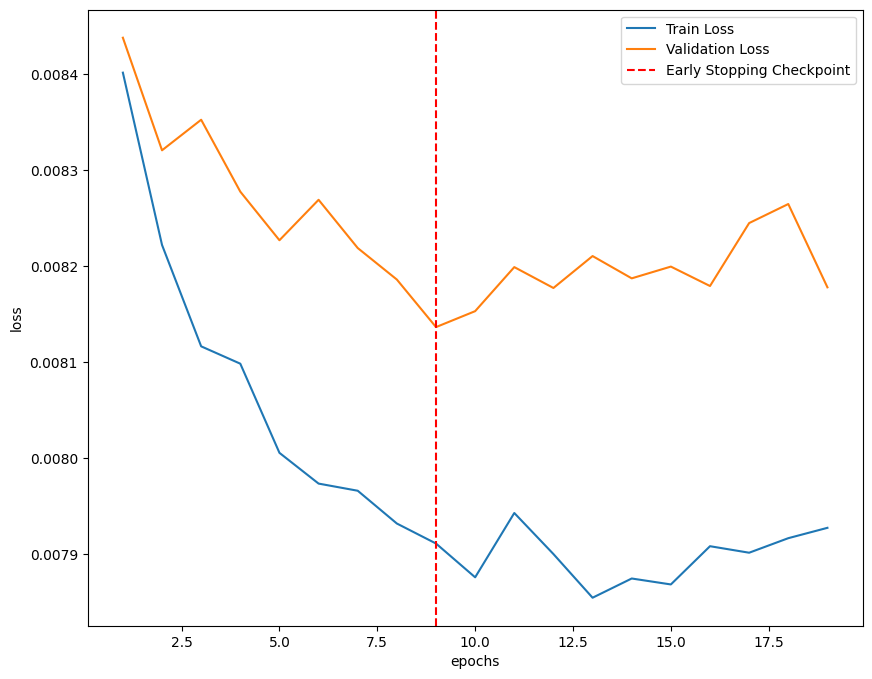

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(tr_loss)+1), tr_loss, label='Train Loss')
plt.plot(range(1, len(te_loss)+1), te_loss, label='Validation Loss')

# find position of lowest validation loss
minposs = te_loss.index(min(te_loss))+1
plt.axvline(minposs, linestyle='--', color='r', label = 'Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [18]:
model = NeuralNetwork(hidden_size=500)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay)
early_stopper = EarlyStopper(patience=patience, min_delta=0)

tr1_loss, tr1_correct = [],[]
te1_loss, te1_correct = [],[]
for t in range(max_epochs):
  train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
  test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)

  tr1_loss.append(train_loss), tr1_correct.append(train_correct)
  te1_loss.append(test_loss), te1_correct.append(test_correct)

  print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

  if early_stopper.early_stop(test_loss):
    print("Done")
    break

Epoch 1: Train_accuracy: 30.42%, Train_loss: 0.008418, Test_accuracy: 35.30%, Test_loss: 0.008407
Epoch 2: Train_accuracy: 35.70%, Train_loss: 0.008222, Test_accuracy: 38.17%, Test_loss: 0.008303
Epoch 3: Train_accuracy: 36.57%, Train_loss: 0.008187, Test_accuracy: 38.40%, Test_loss: 0.008295
Epoch 4: Train_accuracy: 38.20%, Train_loss: 0.008121, Test_accuracy: 36.93%, Test_loss: 0.008348
Epoch 5: Train_accuracy: 39.62%, Train_loss: 0.008075, Test_accuracy: 40.88%, Test_loss: 0.008183
Epoch 6: Train_accuracy: 40.84%, Train_loss: 0.008024, Test_accuracy: 39.10%, Test_loss: 0.008255
Epoch 7: Train_accuracy: 41.83%, Train_loss: 0.007989, Test_accuracy: 41.23%, Test_loss: 0.008178
Epoch 8: Train_accuracy: 42.96%, Train_loss: 0.007951, Test_accuracy: 41.70%, Test_loss: 0.008148
Epoch 9: Train_accuracy: 43.43%, Train_loss: 0.007927, Test_accuracy: 41.30%, Test_loss: 0.008173
Epoch 10: Train_accuracy: 44.11%, Train_loss: 0.007906, Test_accuracy: 43.45%, Test_loss: 0.008088
Epoch 11: Train_acc

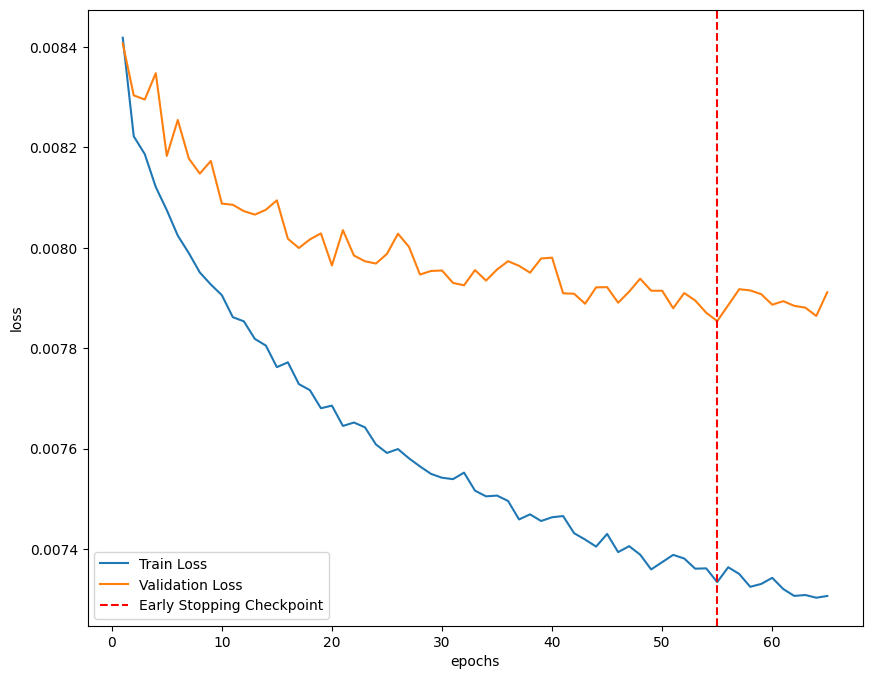

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(tr1_loss)+1), tr1_loss, label='Train Loss')
plt.plot(range(1, len(te1_loss)+1), te1_loss, label='Validation Loss')

# find position of lowest validation loss
minposs = te1_loss.index(min(te1_loss))+1
plt.axvline(minposs, linestyle='--', color='r', label = 'Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [20]:
model = NeuralNetwork_dropout(hidden_size=500, drop_out=dropouts)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
early_stopper = EarlyStopper(patience=patience, min_delta=0)

tr2_loss, tr2_correct = [],[]
te2_loss, te2_correct = [],[]
for t in range(max_epochs):
  model.train()
  train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)

  model.eval()
  test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)

  tr2_loss.append(train_loss), tr2_correct.append(train_correct)
  te2_loss.append(test_loss), te2_correct.append(test_correct)

  print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

  if early_stopper.early_stop(test_loss):
    print("Done")
    break

Epoch 1: Train_accuracy: 31.21%, Train_loss: 0.008384, Test_accuracy: 35.43%, Test_loss: 0.008389
Epoch 2: Train_accuracy: 36.85%, Train_loss: 0.008184, Test_accuracy: 35.95%, Test_loss: 0.008393
Epoch 3: Train_accuracy: 37.51%, Train_loss: 0.008157, Test_accuracy: 36.85%, Test_loss: 0.008349
Epoch 4: Train_accuracy: 37.30%, Train_loss: 0.008170, Test_accuracy: 36.80%, Test_loss: 0.008366
Epoch 5: Train_accuracy: 38.38%, Train_loss: 0.008128, Test_accuracy: 38.22%, Test_loss: 0.008306
Epoch 6: Train_accuracy: 39.86%, Train_loss: 0.008073, Test_accuracy: 39.55%, Test_loss: 0.008253
Epoch 7: Train_accuracy: 40.82%, Train_loss: 0.008040, Test_accuracy: 37.30%, Test_loss: 0.008356
Epoch 8: Train_accuracy: 40.78%, Train_loss: 0.008041, Test_accuracy: 40.98%, Test_loss: 0.008198
Epoch 9: Train_accuracy: 41.92%, Train_loss: 0.007996, Test_accuracy: 41.42%, Test_loss: 0.008184
Epoch 10: Train_accuracy: 42.06%, Train_loss: 0.007991, Test_accuracy: 41.25%, Test_loss: 0.008187
Epoch 11: Train_acc

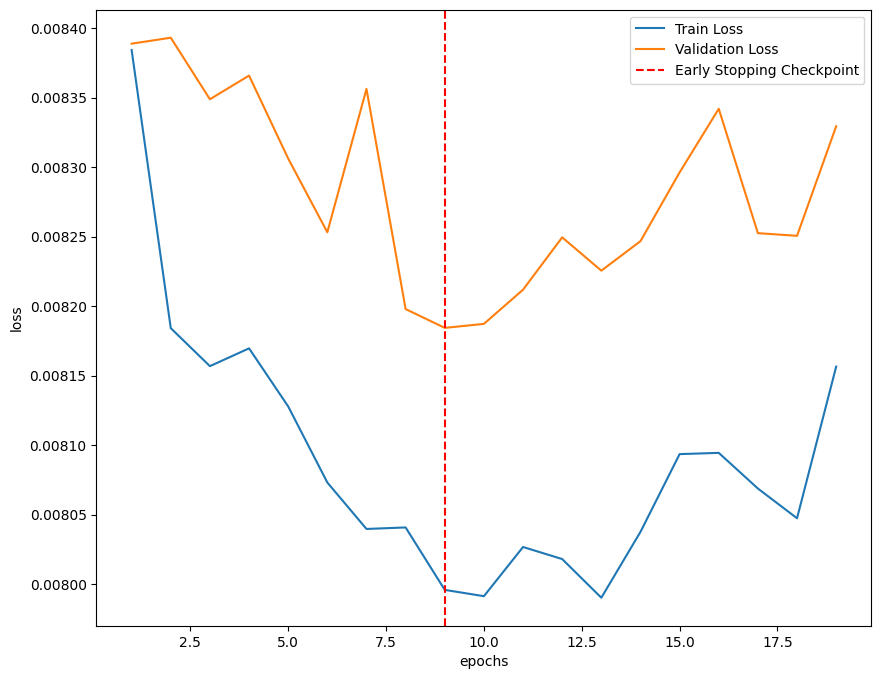

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(tr2_loss)+1), tr2_loss, label='Train Loss')
plt.plot(range(1, len(te2_loss)+1), te2_loss, label='Validation Loss')

# find position of lowest validation loss
minposs = te2_loss.index(min(te2_loss))+1
plt.axvline(minposs, linestyle='--', color='r', label = 'Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [22]:
model = NeuralNetwork_dropout(hidden_size=500, drop_out=dropouts)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay)
early_stopper = EarlyStopper(patience=patience, min_delta=0)

tr3_loss, tr3_correct = [],[]
te3_loss, te3_correct = [],[]
for t in range(max_epochs):
  model.train()
  train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)

  model.eval()
  test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)

  tr3_loss.append(train_loss), tr3_correct.append(train_correct)
  te3_loss.append(test_loss), te3_correct.append(test_correct)

  print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

  if early_stopper.early_stop(test_loss):
    print("Done")
    break

Epoch 1: Train_accuracy: 28.14%, Train_loss: 0.008496, Test_accuracy: 32.30%, Test_loss: 0.008508
Epoch 2: Train_accuracy: 34.58%, Train_loss: 0.008264, Test_accuracy: 35.93%, Test_loss: 0.008384
Epoch 3: Train_accuracy: 37.06%, Train_loss: 0.008164, Test_accuracy: 38.67%, Test_loss: 0.008282
Epoch 4: Train_accuracy: 39.02%, Train_loss: 0.008098, Test_accuracy: 37.88%, Test_loss: 0.008316
Epoch 5: Train_accuracy: 39.86%, Train_loss: 0.008069, Test_accuracy: 41.52%, Test_loss: 0.008173
Epoch 6: Train_accuracy: 40.84%, Train_loss: 0.008027, Test_accuracy: 41.48%, Test_loss: 0.008164
Epoch 7: Train_accuracy: 41.81%, Train_loss: 0.007995, Test_accuracy: 42.08%, Test_loss: 0.008145
Epoch 8: Train_accuracy: 42.48%, Train_loss: 0.007966, Test_accuracy: 41.08%, Test_loss: 0.008185
Epoch 9: Train_accuracy: 42.72%, Train_loss: 0.007961, Test_accuracy: 40.90%, Test_loss: 0.008179
Epoch 10: Train_accuracy: 43.74%, Train_loss: 0.007920, Test_accuracy: 41.35%, Test_loss: 0.008185
Epoch 11: Train_acc

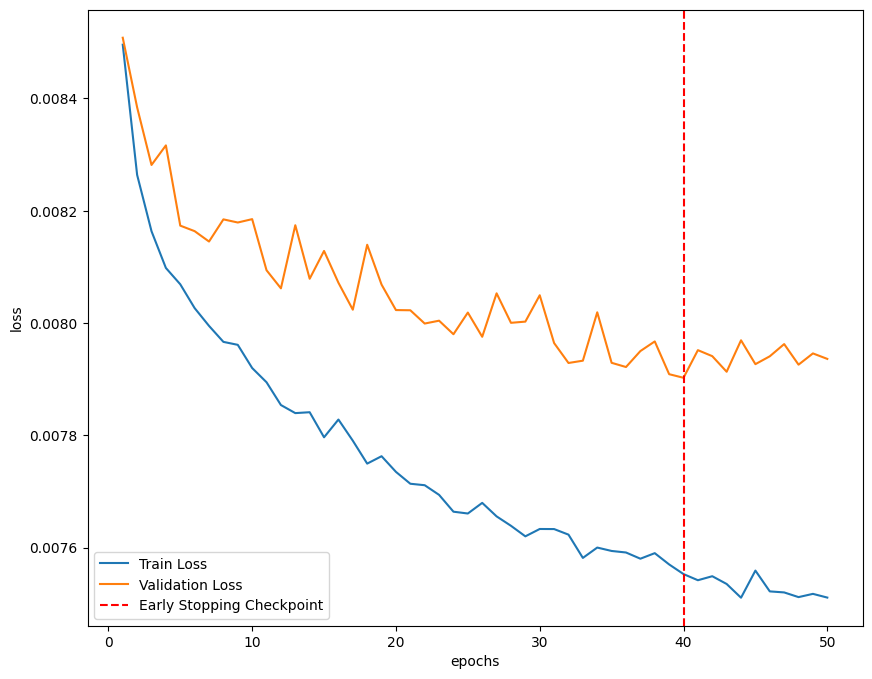

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(tr3_loss)+1), tr3_loss, label='Train Loss')
plt.plot(range(1, len(te3_loss)+1), te3_loss, label='Validation Loss')

# find position of lowest validation loss
minposs = te3_loss.index(min(te3_loss))+1
plt.axvline(minposs, linestyle='--', color='r', label = 'Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

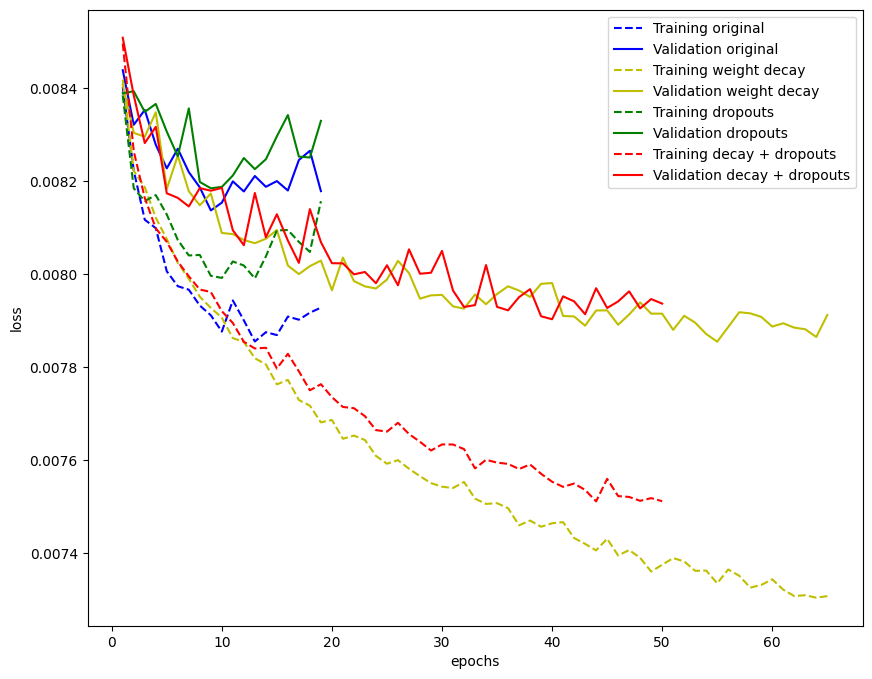

In [25]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr_loss)+1),tr_loss, linestyle='--', color='b', label='Training original')
plt.plot(range(1,len(te_loss)+1),te_loss, color='b', label='Validation original')
plt.plot(range(1,len(tr1_loss)+1),tr1_loss, linestyle='--', color='y', label='Training weight decay')
plt.plot(range(1,len(te1_loss)+1),te1_loss, color='y', label='Validation weight decay')
plt.plot(range(1,len(tr2_loss)+1),tr2_loss, linestyle='--', color='g', label='Training dropouts')
plt.plot(range(1,len(te2_loss)+1),te2_loss, color='g', label='Validation dropouts')
plt.plot(range(1,len(tr3_loss)+1),tr3_loss, linestyle='--', color='r', label='Training decay + dropouts')
plt.plot(range(1,len(te3_loss)+1),te3_loss, color='r', label='Validation decay + dropouts')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()